# DBScan Feature Extraction for PEX Pipe

In [88]:
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from os import listdir
from mpl_toolkits.mplot3d import axes3d
import spectrum_preprocessing as sp
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

Functions

In [89]:
def IR_PCA(input_data, PCs):
    """
    Perform a principle component analysis on a single IR dataset. 
    This function is meant to be used on a dataset containing a single sample.
    It returns the dataframe of the transformed data, the loading dataframe, 
    and the PCA model itself. 
    """
    
    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)
    
    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))
    
    return(PC_df, loadings_df, pca_model)

def trainPCAModel(path: str, trainingFiles: list, PCs: int, modelName: str):
    """
    Train a principle component model and save it to a pickle file. 

    path: Filepath to the data that will be used to train the PCA model. 
    trainingFiles: Filesname for the data that will be used to train the PCA model. 
    modelName: The filename of the pickle file that will contain the PCA model. 
    """
    input_data = pd.concat([pd.read_csv(path+file) for file in trainingFiles])

    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)

    # Save the model to a pickle file
    if modelName.endswith('.pkl'):
        with open(modelName, 'wb') as f:
            pickle.dump(pca_model, f)
            f.close
    else: 
        with open(modelName+'.pkl', 'wb') as f:
            pickle.dump(pca_model, f)
            f.close

    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))

    return PC_df, loadings_df

def distribution_Selection(df: pd.DataFrame, distributionIdx: str, numberOfSigmas: int):
    """
    Screens data based on the distribution of a given column in a pandas dataframe. 
    Built for screening out dataset values that do not have a sufficient 2019 wavenumber 
    integral for the PEX project. Can be modified to projects liking. 

    Returns the selected datas indexes, the discarded indexes, the mask used to select the data,
    the x position of the distribution mode, and the column values of the distribution that is
    being used to screen data. In this case the values of the baseline integral of the PE 2019
    wavenumber peak. 

    :param df: (Pandas df) The dataframe to mask
    :param distributionIdx: (str) The column name containing the values to mask the dataframe based on a distribution of values.
    :param numberOfSigmas: (int) Number of standard deviations away from the mean you want to be selected, this will be the data that is not masked.
    """
    
    
    df[distributionIdx] = df[distributionIdx].astype(float)

    #creating variable for the array of Polyethylene Area
    area = df['1981.7 - 2095.8'].values

    # Use Gaussian KDE to find the center position of the rightmost mode by creating x coords
    # and then using np.argmax to determine the point with the highest number of counts
    kde = gaussian_kde(area)
    xs = np.linspace(area.min(), area.max(), 1000) 
    modePosition = xs[np.argmax(kde(xs))]

    # Use only the values greater than 1.5 to determine the std of the PE peaks
    positive_vals = area[area > 1.5]
    sigma = positive_vals.std()

    lowerDistributionBound = modePosition - numberOfSigmas * sigma
    upperDistributionBound = modePosition + numberOfSigmas * sigma

    # Select the range of PE normalization integral to be accepted by the mask
    mask_selected = (area >= lowerDistributionBound) & (area <= upperDistributionBound)
    selected_indexes = df.index[mask_selected]
    discarded_indexes = df.index[~mask_selected]

    return selected_indexes, discarded_indexes, mask_selected, modePosition, area

def roundWavenumbers(dataframe: pd.DataFrame):
    """
    Function for rounding the wavenumbers so that there is no mismatch between the machine 
    precision of saving the files in Quasar and the wavenumbers output by the FTIR microscope
    """
    last_nonwavenum_idx = dataframe.columns.get_loc('1981.7 - 2095.8') + 1

    dataframe = dataframe.rename(columns=lambda c: round(float(c), 1) if c not in dataframe.columns[:last_nonwavenum_idx] else c)
    
    return dataframe

def pipeline(expt_wavenumber, expt_absorbance):
    f = expt_wavenumber
    a = expt_absorbance
    
    #apply the interpolation to the spectral window
    interpolated_wavenumber, interpolated_absorbance = sp.interpolate_spectrum(f, a, 898, 1200)

    #calculate the baseline
    baseline1 = sp.airpls(interpolated_absorbance)
    #baseline correct the spectrum
    corrected1 = interpolated_absorbance - baseline1

    baseline2 = sp.polynomial_background(interpolated_wavenumber, corrected1,odr=2, s=0.006, fct='atq')[0]
    corrected2 = corrected1 - baseline2

    baseline3 = sp.rubberband_baseline(interpolated_wavenumber, corrected2)
    corrected3 = corrected2 - baseline3

    fingerprint_cm = interpolated_wavenumber
    fingerprint_abs = corrected3
    
    #apply the interpolation to the spectral window
    interpolated_wavenumber, interpolated_absorbance = sp.interpolate_spectrum(f, a, 1520, 1800)
    #calculate the baseline
    baseline1 = sp.airpls(interpolated_absorbance)

    #baseline correct the spectrum
    corrected1 = interpolated_absorbance - baseline1

    baseline2 = sp.rubberband_baseline(interpolated_wavenumber, corrected1)
    corrected2 = corrected1 - baseline2

    carbonyl_cm = interpolated_wavenumber
    carbonyl_abs = corrected2
    
    #apply the interpolation to the spectral window
    interpolated_wavenumber, interpolated_absorbance = sp.interpolate_spectrum(f, a, 1850, 2110)
    #calculate the baseline
    baseline1 = sp.airpls(interpolated_absorbance)
    #baseline correct the spectrum
    corrected1 = interpolated_absorbance - baseline1

    baseline2 = sp.rubberband_baseline(interpolated_wavenumber, corrected1)
    corrected2 = corrected1 - baseline2

    polyethylene_cm = interpolated_wavenumber
    polyethylene_abs = corrected2
    
    def merge_arrays(arr1, arr2, arr3):
        merged_array = np.concatenate((arr1, arr2, arr3))
        return merged_array
    
    wavenumber = merge_arrays(fingerprint_cm, carbonyl_cm, polyethylene_cm)
    absorbance = merge_arrays(fingerprint_abs, carbonyl_abs, polyethylene_abs)
    
    internal_std_int = sp.calculate_peak_intensity(wavenumber, absorbance, (1990,2090))[1]
    absorbance = absorbance/internal_std_int
    Std = sp.integrate_peak(wavenumber, absorbance, low=2000, high=2050)
    Abs = absorbance[0:584]
    
    return (wavenumber[0:584], Abs) 

Manage the Dataset

In [ ]:
"""
Here we are choosing that dataset that we are going to look at using the PCA model
"""

trainingStdDevs = 2

path ='../data/'
filename = path + 'SMP65#010 100d 820um'
filename += '.csv'

test_df = pd.read_csv(filename, low_memory=False, skiprows=[1,2])

# Create an array of strings containing the wavenumbers
test_df = roundWavenumbers(test_df)

#print(wavenumbers)

allFiles = listdir(path)

testFiles = [file for file in allFiles if 'SMP65#010' in file and file.endswith('.csv') and 'full width' not in file]
testFiles = sorted(testFiles, key=lambda x: int(re.search(r'(?<= )(.+?)(?=d)', x).group()))
testFiles = ['SMP65#010 100d 820um.csv']

print(f'Files to test the PCA model on:\n {testFiles}')
testDataframeList = [pd.read_csv(path+file, low_memory=False, skiprows=[1,2]) for file in testFiles]

# Obtain the last Index before starting wavenumbers, this may change depending on data
last_nonwavenum_idx = testDataframeList[0].columns.get_loc('1981.7 - 2095.8') + 1

for i, df in enumerate(testDataframeList):
    
    df = roundWavenumbers(df)
    
    wavenumbers = df.columns[last_nonwavenum_idx:].astype(float)
    
    wavenumbers = sorted(wavenumbers)

    spectra_df = df[wavenumbers].copy()

    np.dtype(spectra_df.columns.values.astype(float)[0])


    for j in range(spectra_df.shape[0]):
        
        absorbance = spectra_df.iloc[j,:].values

        normalizedWavenumbers, normalizedAbsorbance = pipeline(wavenumbers, absorbance)

        if j == 0: 
            normalizedDataframe = pd.DataFrame(
            normalizedAbsorbance.reshape(1, -1),
            columns=normalizedWavenumbers)
        else:
            normalizedDataframe = pd.concat([normalizedDataframe, 
            pd.DataFrame(normalizedAbsorbance.reshape(1, -1), 
            columns=normalizedDataframe.columns)])

        print(normalizedDataFrame)
    testDataframeList[i] = normalizedDataframe

"""
This part is for training PCA on multiple datasets
"""

#List all of the files in the data directory.
allFiles = listdir(path)
# Take only the files that contain data pertaining to SMP65#010 
trainingFiles = [file for file in allFiles if 'SMP65#010' in file and file.endswith('.csv') and 'full width' not in file]

trainingFiles = sorted(trainingFiles, key=lambda x: int(re.search(r'(?<= )(.+?)(?=d)', x).group()))

print(f'Files to train the PCA model on:\n {trainingFiles}')

# Read all of the data and place the dataframes into a list
trainingDataframeList = [pd.read_csv(path+file, low_memory=False, skiprows=[1,2]) for file in trainingFiles]

for i, df in enumerate(trainingDataframeList):
    df = roundWavenumbers(df)
    trainingDataframeList[i] = spectraPipeline(df)

# Lambda function to round all of the wavenumbers so that they are all matching, and then concatenate all the datasets together
rawTrainingDataframe = pd.concat(trainingDataframeList, ignore_index=True)


#rawTrainingDataframe['aged_time'] = rawTrainingDataframe['Sample Name'].str.strip().str.extract(r'(\d+)').astype(int)

# Sort by the extracted numeric value
#rawTrainingDataframe = rawTrainingDataframe.sort_values('aged_time').drop(columns='aged_time').reset_index()

wavenumbers = rawTrainingDataframe.columns[last_nonwavenum_idx:]
#print(wavenumbers)
print(f"Number of wavenumbers: {wavenumbers.size}")

print(rawTrainingDataframe)


Files to test the PCA model on:
 ['SMP65#010 100d 820um.csv']


NameError: name 'normalizedDataFrame' is not defined

Look at the Distribution of PE Integrals and show the selected region

In [ ]:
if False:
    bin_width = 0.05
    bins = np.arange(min(areaPE), max(areaPE) + bin_width, bin_width)

    plt.hist(areaPE,bins=bins, color='r')
    plt.hist(areaPE[mask_selected], bins=bins, color='b')
    plt.yticks([])
    plt.xticks(fontsize=16)
    plt.ylabel('Number of Counts', fontsize=16)
    plt.xlabel(f'Area of 2019cm$^-$$^1$ PE Peak', fontsize=16)
    plt.legend(['Discarded Data', 'Selected Data'], fontsize=16, loc='upper left')
    plt.xlim([-1, modePosition + 2])

Plot the Average Masked Spectra

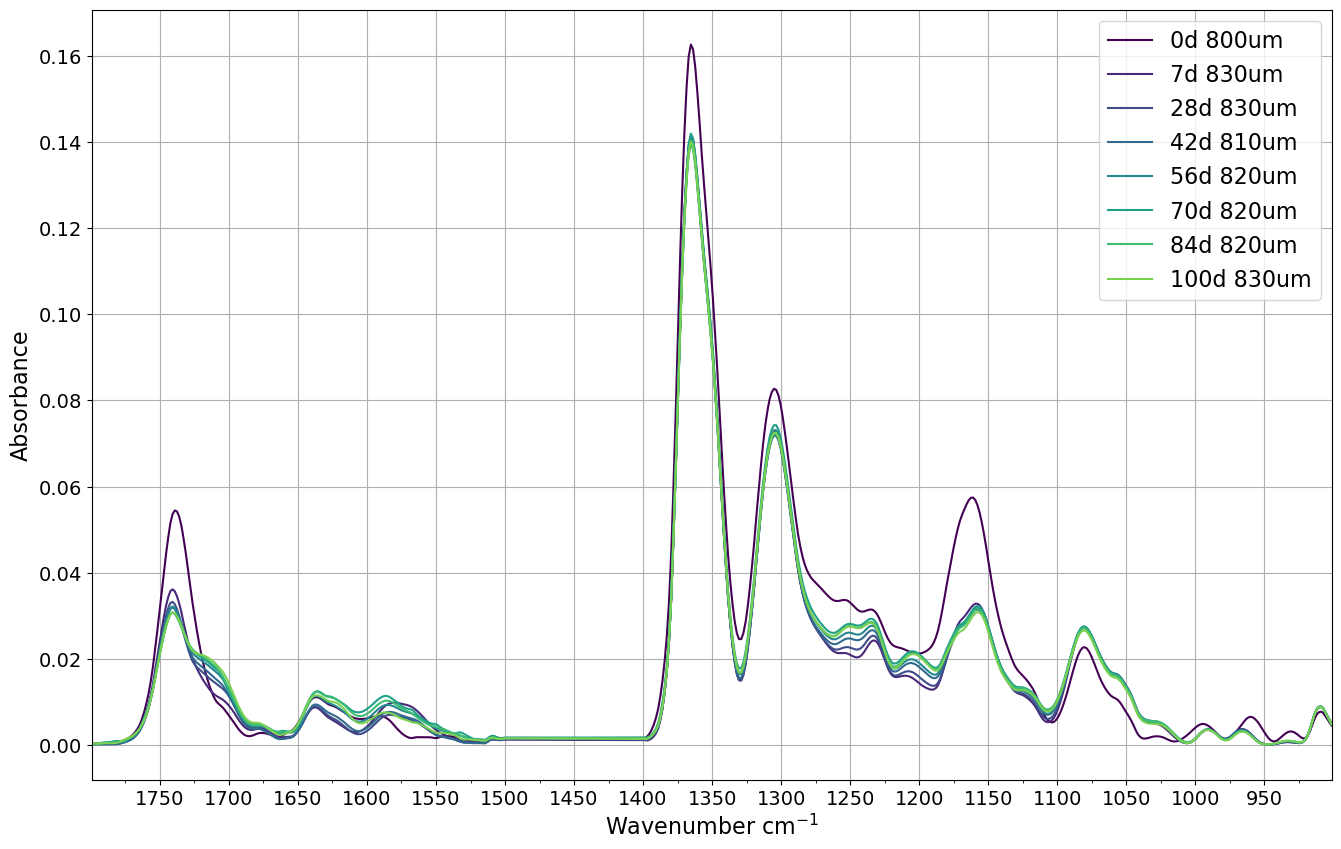

In [ ]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(rawTrainingDataframe['Sample Name'].unique())))

plt.figure(figsize=(16,10))
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16)
plt.ylabel('Absorbance', fontsize=16)
plt.xticks(np.arange(900, 1800, step=50), fontsize=14, minor=False)
plt.xticks(np.arange(900, 1800, step=25), fontsize=0, minor=True)
plt.yticks(fontsize=14)

stdDevs = 2
newTrainingData = []

i=0
for df in trainingDataframeList:

    df = roundWavenumbers(df)

    selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(df, '1981.7 - 2095.8', stdDevs)

    selectedData = df[mask_selected].copy()

    spectra = selectedData[wavenumbers].mean()

    spectra = savgol_filter(spectra, 9,1)

    plt.plot(
        wavenumbers,
        spectra,
        color=colors[i],
        label=f"{df['Sample Name'][0]}"
    )
    i+=1

legend_labels = rawTrainingDataframe['Sample Name'].unique()
plt.legend(legend_labels, fontsize=16, loc='upper right')
plt.xlim(wavenumbers[0], wavenumbers[-1])
plt.grid()

Perform the PCA Analysis and Plot Loading Spectra

In [ ]:
PCs = 2

selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(rawTrainingDataframe, '1981.7 - 2095.8', stdDevs)

# Create dataset containing ONLY the wavenumbers
rawData = rawTrainingDataframe[wavenumbers].copy()

window_length = 13
polyorder = 1

rawData_smoothed = pd.DataFrame(
    savgol_filter(rawData, window_length, polyorder, axis=1), 
    columns=rawData.columns, 
    index=rawData.index
)

# Modify created dataset to contain ONLY the masked values
masked_PC_inputData = rawData[mask_selected]

# Train a PCA model on the masked values 
PCA_df_init, loadings_df_init, pca_model = IR_PCA(masked_PC_inputData, PCs=PCs)

print("Raw Dataset shape: ", rawData.shape, "Filtered Dataset shape: ", masked_PC_inputData.shape)

# Save the model to a pickle file
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_model, f)
# Open the same model
with open('pca_model.pkl', 'rb') as f:
    loaded_pca_model = pickle.load(f)


Explained variation per principal component: [0.42881341 0.33224392]
Raw Dataset shape:  (46080, 505) Filtered Dataset shape:  (40487, 505)


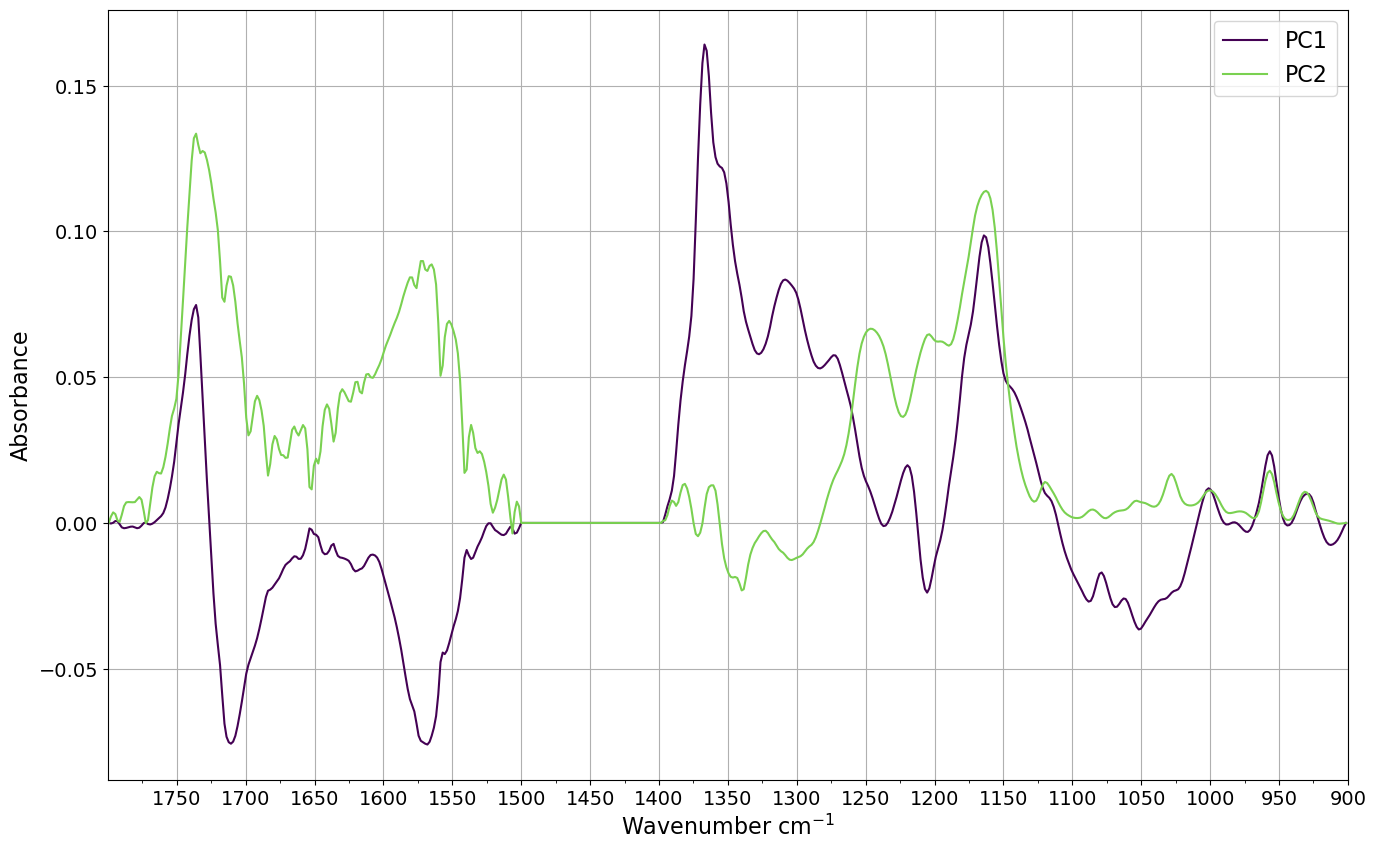

In [ ]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, PCs))

plt.figure(figsize=(16,10))
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16)
plt.ylabel('Absorbance', fontsize=16)
plt.xticks(np.arange(900, 1800, step=50), fontsize=14, minor=False)
plt.xticks(np.arange(900, 1800, step=25), fontsize=0, minor=True)

plt.yticks(fontsize=14)
for i in range(PCs):
    #loadings = savgol_filter(loadings_df_init.iloc[i, :].values, 7, 1)
    loadings = loadings_df_init.iloc[i, :].values
    plt.plot(
        wavenumbers,
        loadings,
        color=colors[i],
        label=f"PC{i+1}"
    )

legend_labels = [f'PC{i+1}' for i in range(PCs)]
plt.legend(legend_labels, fontsize=16, loc='upper right')
#plt.xlim(wavenumbers[0], wavenumbers[-1])
plt.grid()
plt.xlim(1800, 900)
plt.savefig("PCs_loading_spectrum.png", dpi=900)

Calculating the PCA Reconstruction Error on the Training Data

In [ ]:
"""
For every dataframe in the training Dataframe list, transform the dataset and then calculate the error in each reconstruction
"""
if False:
    for df in trainingDataframeList:

        raw_data = df[wavenumbers].values

        df_data = loaded_pca_model.transform(df[wavenumbers].values)

        reversed_df_data = loaded_pca_model.inverse_transform(df_data)

        #print(raw_data.shape) # raw_data[0] should be same length as map_x

        reconstruction_error = []
        for i in range(raw_data.shape[0]):
            reconstruction_error.append(mean_squared_error(df[wavenumbers].iloc[i,:].values, reversed_df_data[i]))

        print('Sample: ', df['Sample Name'][0])

        print(f"Reconstruction Error (MSE): {reconstruction_error}\n")



# Transforming the test dataset

In [ ]:
"""
For every dataframe in the test Dataframe list, round the wavenumbers, select the PE distribution, 
transform the data and concatenate it into a singular pandas dataframe. 

"""

testingStdDevs = 3

testDataframeTransformed = []

for df in testDataframeList:

    df = roundWavenumbers(df)
    
    selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(df, '1981.7 - 2095.8', testingStdDevs)

    PC_data = df[wavenumbers].copy()

    # Use the model again on the unmasked values to get the same result for the complete dataset
    data_PCs = loaded_pca_model.transform(PC_data.values)
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]

    transformed_df = pd.DataFrame(data = data_PCs[mask_selected], columns = columns_list)

    transformed_df['Aging Times'] = df['Sample Name']

    testDataframeTransformed.append(transformed_df)


testDataframeTransformed = pd.concat(testDataframeTransformed)

selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(test_df, '1981.7 - 2095.8', testingStdDevs)

rawTestData = test_df[wavenumbers].copy()

# Use the model again on the unmasked values to get the same result for the complete dataset
data_PCs = loaded_pca_model.transform(rawTestData)
columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
PCA_df = pd.DataFrame(data = data_PCs[mask_selected], columns = columns_list)



# Plotting the transformed test dataset PCs

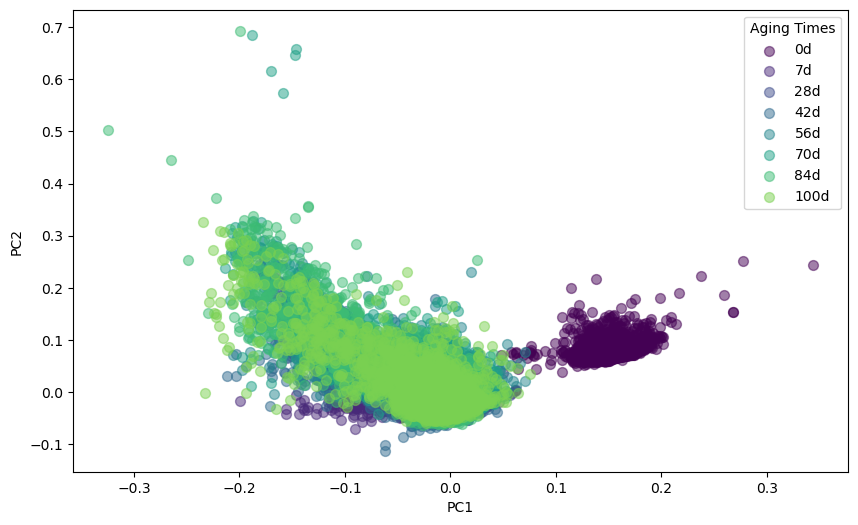

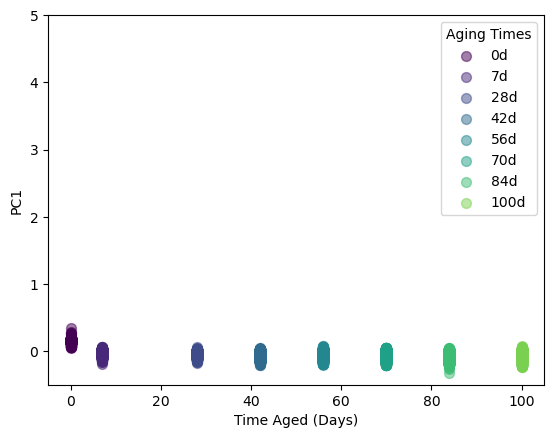

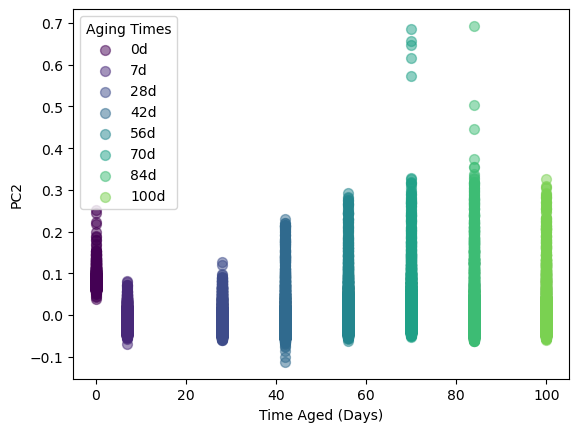

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
SCATTER PLOTS OF PCAs

Plot two PCs against each other and color by aging time to see how they vary
"""
colour_list=[]
plt.figure(figsize=(10,6))
unique_samples = testDataframeTransformed['Aging Times'].unique()
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(unique_samples)))
i=0
for sample in unique_samples:
    
    subset = testDataframeTransformed[testDataframeTransformed['Aging Times'] == sample]

    plt.scatter(subset['PC1'].values, subset['PC2'].values,
                alpha=0.5,
                s=50,
                label=sample.split(" ")[0], color=colors[i])
    i+=1
plt.xlabel('PC1')
#plt.xlim((-.25, 1))
plt.ylabel('PC2')
#plt.ylim((-0.5, 1))
plt.legend(title='Aging Times')
plt.show()
plt.savefig("PCs_plot.jpeg", dpi=900)

"""
Principal Component One versus Aging time
"""

i=0
unique_samples_int = [int(sample.split(' ')[0][:-1]) for sample in unique_samples]
for sample in unique_samples:
    
    subset = testDataframeTransformed[testDataframeTransformed['Aging Times'] == sample]

    aged_time = [int(string.split(' ')[0][:-1]) for string in subset['Aging Times']]

    plt.scatter(aged_time, subset['PC1'].values,
                alpha=0.5,
                s=50,
                label=sample.split(" ")[0], color=colors[i])
    i+=1
plt.xlabel('Time Aged (Days)')
#plt.xlim((-.25, 1))
plt.ylabel('PC1')
plt.ylim((-0.5, 5))
plt.legend(title='Aging Times')
plt.show()
plt.savefig("PCs_plot.jpeg", dpi=900)

"""
Principal Component Two versus Aging time
"""

i=0
unique_samples_int = [int(sample.split(' ')[0][:-1]) for sample in unique_samples]
for sample in unique_samples:
    
    subset = testDataframeTransformed[testDataframeTransformed['Aging Times'] == sample]

    aged_time = [int(string.split(' ')[0][:-1]) for string in subset['Aging Times']]

    plt.scatter(aged_time, subset['PC2'].values,
                alpha=0.5,
                s=50,
                label=sample.split(" ")[0], color=colors[i])
    i+=1
plt.xlabel('Time Aged (Days)')
#plt.xlim((-.25, 1))
plt.ylabel('PC2')
#plt.ylim((-0.5, 5))
plt.legend(title='Aging Times')
plt.show()
plt.savefig("PCs_plot.jpeg", dpi=900)


"""
Plot three PCs in a meshgrid and color by aging time
"""
if False: 
    PC1 = PCA_df['PC1'].to_numpy() 
    PC2 = PCA_df['PC2'].to_numpy()
    PC3 = PCA_df['PC3'].to_numpy()

    X, Y, Z = np.meshgrid(PC1[::100], PC2[::100], PC3[::100])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, cmap='viridis')
    plt.show()


# Plotting the PCA Spatial Analysis

Preparing data for plottings

In [ ]:


selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(test_df, '1981.7 - 2095.8', testingStdDevs)
# Use the model again on the unmasked values to get the same result for the complete dataset
data_PCs = loaded_pca_model.transform(test_df[wavenumbers].values)
columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
PCA_df = pd.DataFrame(data = data_PCs, columns = columns_list)

PC1 = PCA_df['PC1'].to_numpy()
PC2 = PCA_df['PC2'].to_numpy()
#PC3 = PCA_df['PC3'].to_numpy()

#Reposition the mapping to start at 0,0 
Map_x = test_df['map_x'].to_numpy()
Map_y = test_df['map_y'].to_numpy()
Map_y2 = []
Map_x2 = []
Min_x = min(Map_x)
Min_y = min(Map_y)

Map_x2 = Map_x - Min_x
Map_y2 = Map_y - Min_y

x_adjusted=(np.unique(Map_x2)).tolist()
y_adjusted=(np.unique(Map_y2)).tolist()

X, Y = np.meshgrid(x_adjusted, y_adjusted)

Xsize, Ysize = len(x_adjusted), len(y_adjusted)
print("Length of X, Y: ", Xsize, Ysize, "\n")

print("Length of X*Y: ",len(x_adjusted)*len(y_adjusted), "\n")

print("Lenght of PC1: ", len(PC1), "Legnth of PC2: ", len(PC2), "\n")
# Format PC1 for plotting
PC1resized = np.reshape(PC1, (Ysize, Xsize))

# Format PC2 for plotting
PC2resized = np.reshape(PC2, (Ysize,Xsize))

# Format PC2 for plotting
#PC3resized = np.reshape(PC3, (Ysize,Xsize))




Length of X, Y:  64 96 

Length of X*Y:  6144 

Lenght of PC1:  6144 Legnth of PC2:  6144 



Creating Figures and Plotting the PCs

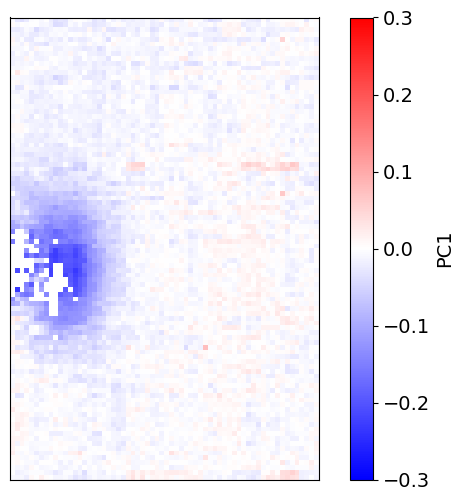

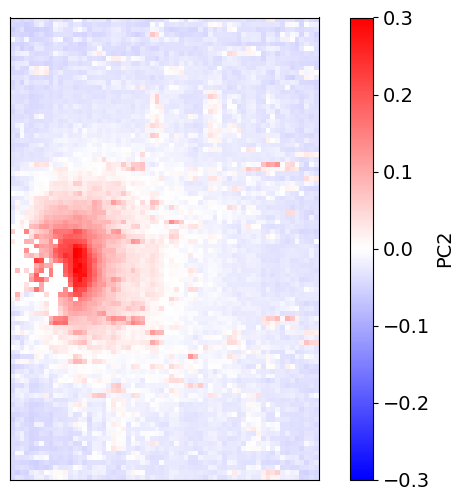

In [ ]:
# Prepare colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(loadings_df_init)))
cmap.set_bad(color='0.7')  # dull grey for masked values

# Setting up the mask for plotting
PC1_masked = np.ma.array(PC1resized, mask=~mask_selected)
PC2_masked = np.ma.array(PC2resized, mask=~mask_selected)
#PC3_masked = np.ma.array(PC3resized, mask=~mask_selected)

"""
Plotting the first Principal Component
"""

fig1, ax1 = plt.subplots(figsize=(8, 6))

im1 = ax1.pcolormesh(X, Y, PC1_masked, cmap='bwr', shading='auto')
im1.set_clim(-0.3, 0.3)

cbar = fig1.colorbar(im1, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC1', fontsize=14)

ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

"""
Plotting the second Principal Component 
"""

fig2, ax2 = plt.subplots(figsize=(8, 6))

im2 = ax2.pcolormesh(X, Y, PC2_masked, cmap='bwr', shading='auto')
im2.set_clim(-0.3, 0.3)

cbar = fig2.colorbar(im2, ax=ax2)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC2', fontsize=14)

ax2.set_aspect('equal')

ax2.set_xticks([])
ax2.set_yticks([])

if PCs > 2:
    fig3, ax3 = plt.subplots(figsize=(8, 6))

    im3 = ax3.pcolormesh(X, Y, PC3_masked, cmap='bwr', shading='auto')
    im3.set_clim(-0.3, 0.3)
    
    cbar = fig3.colorbar(im3, ax=ax3)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(r'PC3', fontsize=14)

    ax3.set_aspect('equal')

    ax3.set_xticks([])
    ax3.set_yticks([])
